In [170]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/Show: Raw Code"></form>''')

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

from manny_wrangle import *
from env import *

<img src="title.png" alt="title.png" width="800"/>

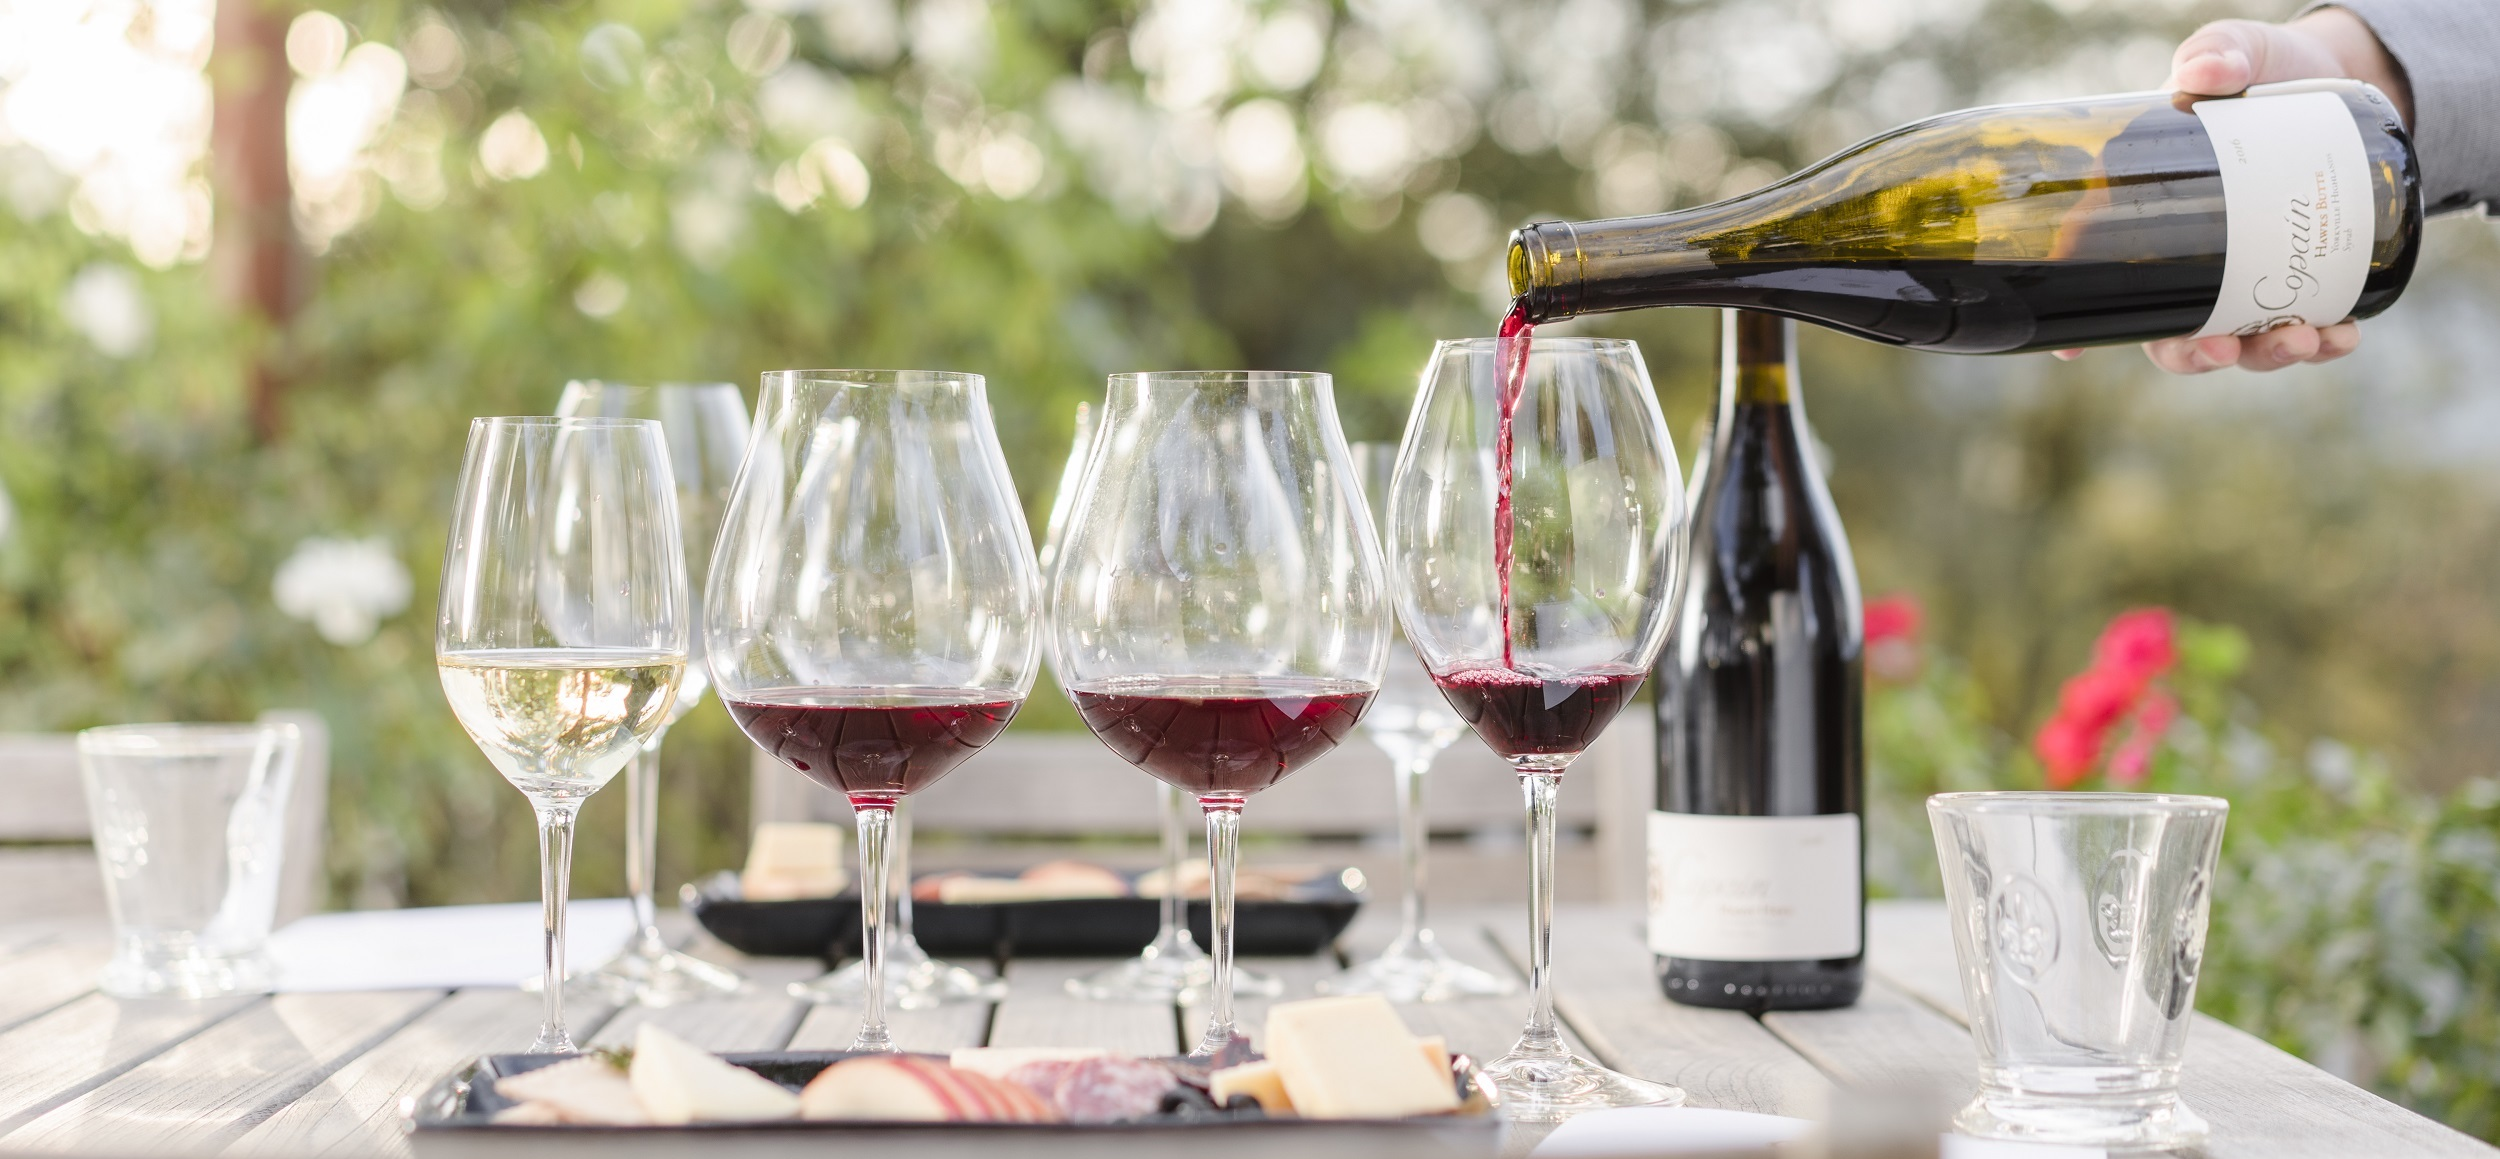

# Acquire

In [126]:
# acquiring data from csv for red & white wines
wine_red = pd.read_csv('winequality-red.csv')
wine_white = pd.read_csv('winequality-white.csv')

In [127]:
wine_red['wine_color']='red'

In [128]:
wine_white['wine_color']='white'

# Concatenate

In [129]:
frames = [wine_red,wine_white]

In [130]:
wines = pd.concat(frames)

# Renaming

In [131]:
rename_columns(wines)

In [132]:
wines.reset_index(drop=True)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


### Types

In [133]:
wines["free_sulfur_dioxide"] = wines["free_sulfur_dioxide"].astype(int)
wines["total_sulfur_dioxide"] = wines["total_sulfur_dioxide"].astype(int)

### Outliers

In [134]:
def remove_outliers(df,col_list,k):
    ''' 
    This function takes in a dataframe, the threshold and a list of columns 
    and returns the dataframe with outliers removed
    '''   
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [135]:
col_list = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
                            'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                            'total_sulfur_dioxide', 'density', 'ph', 'sulphates',
                            'alcohol']
wines = remove_outliers(wines, col_list, k=1.5)

# Model

### Split

In [136]:
def split_data(df, target):
    '''
    This function take in a dataframe performs a train, validate, test split
    Returns train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
    and prints out the shape of train, validate, test
    '''
    #create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    #create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)

    #Split into X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    # Have function print datasets shape
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
   
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [137]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(wines,'quality')

train -> (2548, 13)
validate -> (1092, 13)
test -> (910, 13)


### Baseline

In [138]:
# code to generate baseline 
wines['baseline'] = wines['quality'].value_counts().idxmax()
# clean f string
print(f"Baseline: {(wines['quality'] == wines['baseline']).mean()*100:.2f}%")

Baseline: 45.58%


### Scale

In [142]:
num,cat = separate_column_type_list(train)

In [143]:
train_scaled = train[num]

In [144]:
# Create Object

In [145]:
mm_scaler = MinMaxScaler()
train_scaled[num] = mm_scaler.fit_transform(train_scaled[num])

In [146]:
train_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
119,0.530612,0.428571,0.847826,0.692098,0.718310,0.743243,0.767347,0.759780,0.285714,0.462963,0.137931
1921,0.591837,0.089286,0.543478,0.474114,0.746479,0.513514,0.481633,0.649966,0.506494,0.259259,0.206897
134,0.428571,0.339286,0.282609,0.408719,0.352113,0.716216,0.795918,0.615649,0.480519,0.500000,0.086207
940,0.306122,0.464286,0.413043,0.376022,0.352113,0.513514,0.771429,0.529856,0.415584,0.648148,0.224138
2768,0.612245,0.392857,0.543478,0.032698,0.549296,0.027027,0.453061,0.254633,0.467532,0.166667,0.637931
...,...,...,...,...,...,...,...,...,...,...,...
4884,0.367347,0.446429,0.630435,0.419619,0.549296,0.891892,0.677551,0.534660,0.415584,0.462963,0.206897
21,0.346939,0.410714,0.630435,0.125341,0.408451,0.229730,0.383673,0.279341,0.454545,0.185185,0.448276
1165,0.265306,0.285714,0.500000,0.310627,0.295775,0.432432,0.493878,0.512697,0.909091,0.296296,0.344828
4658,0.489796,0.625000,0.347826,0.119891,0.380282,0.554054,0.506122,0.179822,0.506494,0.407407,0.862069


# Cluster

In [147]:
seed = 42
cluster_count = 4

kmeans = KMeans(n_clusters=cluster_count,random_state=seed)
kmeans.fit(train_scaled)

KMeans(n_clusters=4, random_state=42)

# Fixed

In [148]:
train['clusters']=kmeans.predict(train_scaled)

In [149]:
train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_color,clusters
119,7.3,0.32,0.48,13.3,0.060,57,196,0.99820,3.04,0.50,9.2,5,white,1
1921,7.6,0.13,0.34,9.3,0.062,40,126,0.99660,3.21,0.39,9.6,5,white,1
134,6.8,0.27,0.22,8.1,0.034,55,203,0.99610,3.19,0.52,8.9,5,white,1
940,6.2,0.34,0.28,7.5,0.034,40,197,0.99485,3.14,0.60,9.7,5,white,1
2768,7.7,0.30,0.34,1.2,0.048,4,119,0.99084,3.18,0.34,12.1,6,white,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,6.5,0.33,0.38,8.3,0.048,68,174,0.99492,3.14,0.50,9.6,5,white,1
21,6.4,0.31,0.38,2.9,0.038,19,102,0.99120,3.17,0.35,11.0,7,white,3
1165,6.0,0.24,0.32,6.3,0.030,34,129,0.99460,3.52,0.41,10.4,5,white,2
4658,7.1,0.43,0.25,2.8,0.036,43,132,0.98975,3.21,0.47,13.4,6,white,3


# Visualize

### Visual #1

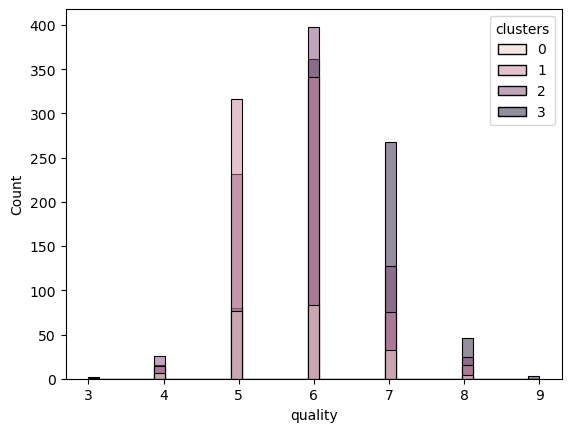

In [150]:
sns.histplot(data=train,x='quality',hue="clusters")
plt.show()

### Visual #2

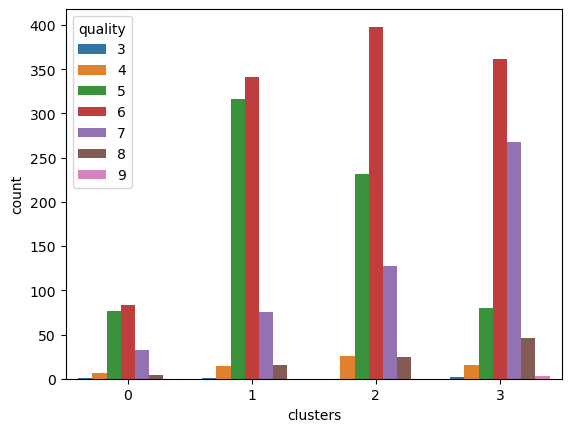

In [151]:
sns.countplot(data=train,x='clusters',hue="quality")
plt.show()

### Visual #3

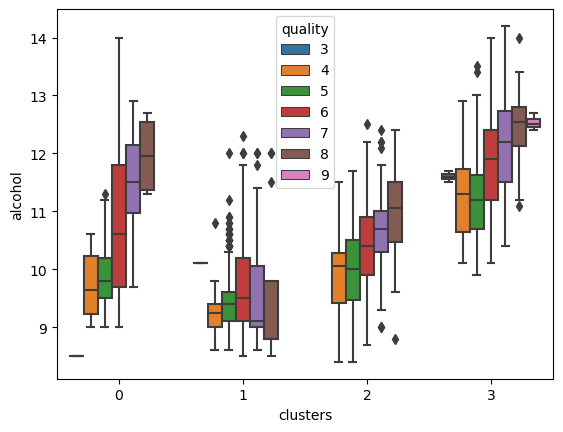

In [152]:
sns.boxplot(data=train,x='clusters',y='alcohol',hue='quality')
plt.show()

### Visual #4

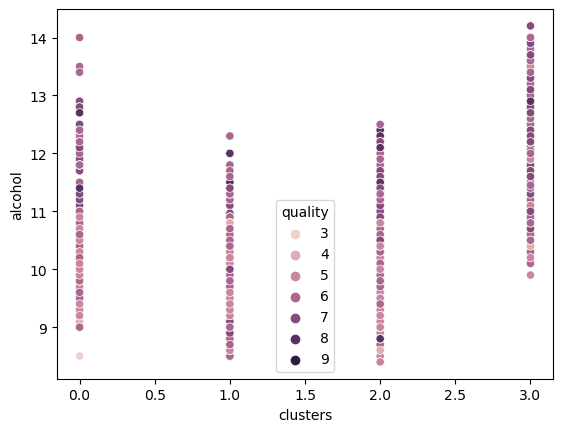

In [153]:
sns.scatterplot(data=train,x='clusters',y='alcohol',hue='quality')
plt.show()

### Visual #5

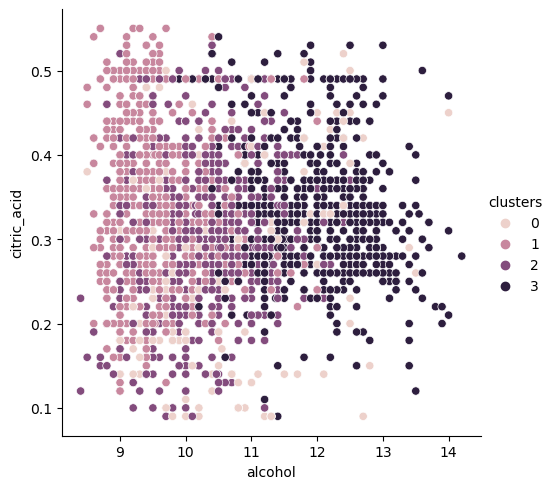

In [154]:
sns.relplot(data=train,x="alcohol",y="citric_acid",hue='clusters')
plt.show()

### Visual #6

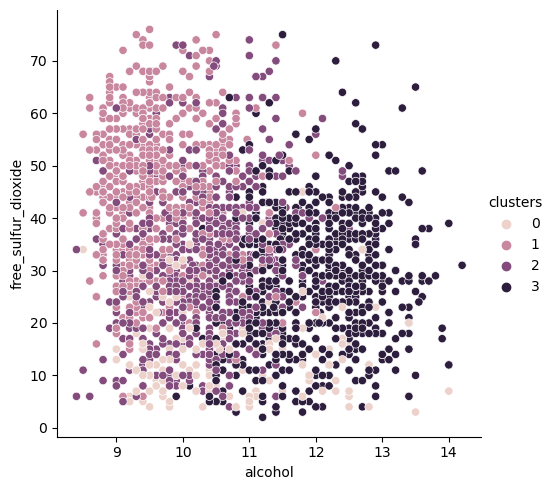

In [155]:
sns.relplot(data=train,x="alcohol",y="free_sulfur_dioxide",hue='clusters')
plt.show()

# Evaluate

In [168]:
def eval_results_2(p, alpha, group1, group2):
    '''
        Test Hypothesis  using Statistics Test Output.
        This function will take in the p-value, alpha, and a name for the 2 variables
        you are comparing (group1 and group2) and return a string stating 
        whether or not there exists a relationship between the 2 groups. 
    '''
    if p < alpha:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Reject $H_0$"))
        display(Markdown( f'There exists some relationship between {group1} and {group2}. (p-value: {p:.4f})'))
    
    else:
        display(Markdown(f"### Results:"))
        display(Markdown(f"### Failed to Reject $H_0$"))
        display(Markdown( f'There is not a significant relationship between {group1} and {group2}. (p-value: {p:.4f})'))

def question_hypothesis_test(question_number,df,question,column_name,target,alpha=.05):
    num, cat = separate_column_type_list(df)
    
    if (target in cat) and (column_name in num):
        # calculation
        overall_alcohol_mean = wines[column_name].mean()
        quality_sample = wines[wines[target] >= 7][target]
        t, p = stats.ttest_1samp(quality_sample, overall_alcohol_mean)
        value = t
        p_value = p/2
        
        # Output variables
        test = "1-Sample T-Test"

        # Markdown Formatting
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{column_name}` and `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{column_name}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        eval_results_2(p_value, alpha, column_name, target)
        
    elif (target in cat) and (column_name in cat):
        # calculations
        observed = pd.crosstab(df[column_name], df[target])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        value = chi2
        p_value = p
        
        # Output variables
        test = "Chi-Square"

        # Markdown Formatting
        display(Markdown(f"# Question #{question_number}:"))
        display(Markdown(f"# {question}"))
        display(Markdown(f"### Hypothesis:"))
        display(Markdown(f"$H_0$: There is no relationship between `{column_name}` to `{target}`"))
        display(Markdown(f"$H_A$: There is a relationship between `{column_name}` and `{target}` "))
        display(Markdown(f"### Statistics Test:"))
        display(Markdown(f"### `{test} = {value}`"))

        eval_results_2(p_value, alpha, column_name, target)
    else:
        print("write code for different test")

In [161]:
for i in (train.columns.values):
    print(i)

fixed_acidity
volatile_acidity
citric_acid
residual_sugar
chlorides
free_sulfur_dioxide
total_sulfur_dioxide
density
ph
sulphates
alcohol
quality
wine_color
clusters


In [162]:
group_1 = 'clusters'

In [163]:
group_2 = 'quality'

In [164]:
question_1 = "Is there correlation between clusters and quality?"

In [169]:
question_hypothesis_test(1,train,question_1,group_1,group_2)

# Question #1:

# Is there correlation between clusters and quality?

### Hypothesis:

$H_0$: There is no relationship between `clusters` to `quality`

$H_A$: There is a relationship between `clusters` and `quality` 

### Statistics Test:

### `Chi-Square = 314.7641600695856`

### Results:

### Reject $H_0$

There exists some relationship between clusters and quality. (p-value: 0.0000)